# CI data analysis: availability sequences based on a common carbon budget

In [25]:
# Import libraries:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from utils import *
import math

from scipy import optimize
from scipy.optimize import milp

from gekko import GEKKO
from scipy.optimize import linprog
import cvxpy as cp
import copy

## Introduction

**Set values for countries and dates:**

In [2]:
# Number of FL training rounds:
n_rounds = 100

# Common carbon budget
global_carbon_budget = 7 # kgCO2e

# Uniform carbon budget
carbon_budget = 1 # kgCO2eq

# list of countries/clients:
countries = ['Ireland', 'Germany', 'Great Britain', 'France', 'Sweden', 'Finland', 'Belgium']
list_colors = ['blue', 'green', 'orange', 'red', 'purple', 'pink', 'yellow']

**Definition of variables and useful functions:**

In [3]:
main_folder = 'figures/av-mat-2'

key_words = []
folders = []

n_clients = len(countries)

# Start and end dates:
start_date = datetime(2022, 1, 1, 0, 0) # year, month, day, hour, min
end_date = start_date + timedelta(hours=n_rounds-1)

# data preparation:
_dfs = load_data()
datetime_values = get_datetime_values(_dfs, countries[0], start_date, end_date)

# initialize the similarity matrix:
time_values = pd.to_datetime(datetime_values.astype('datetime64[ns]')).to_list()
# formatted_array = [dt.strftime("%d %h, %H:%M") for dt in time_values]
formatted_array = [i for i in range(n_rounds)]

# functions:
def save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix):
    dict_cols = dict(zip(formatted_array, datetime_values)) # get the datetime values
    availability_matrix_to_save = availability_matrix.rename(columns=dict_cols)
    availability_matrix_to_save.to_csv('availability_matrices/av-mat-2/av-mat_'+key_word+'.csv', columns=datetime_values)

**Raw CI data:**

Let us display the raw data in between the chosen dates.

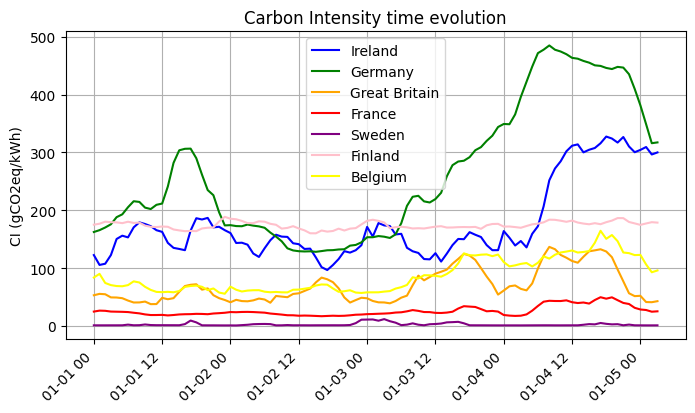

In [4]:
fig = plt.figure(figsize=(8, 4))

for country_idx, country in enumerate(countries):

    df_country = _dfs[country]
    df_to_plot = df_country[df_country['datetime'].between(start_date,end_date)]

    # plot:
    plt.plot(df_to_plot['datetime'].values, df_to_plot['CI_direct'].values, label=country, color = list_colors[country_idx])

    # plot legend, axis, etc.:
    # ax.set_xlim([df_to_plot['datetime'].values[0], df_to_plot['datetime'].values[-1]])
    plt.title('Carbon Intensity time evolution')
    plt.legend()
    # ax.xaxis.set_major_formatter(mdates.DateFormatter("%d"))
    # ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
    _ = plt.xticks(rotation=90)  
    plt.grid()
    plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
    plt.ylabel('CI (gCO2eq/kWh)')
plt.savefig(os.path.join('figures/av-mat-2/raw_CI_data.png'), bbox_inches='tight')
plt.show()

Lets compute the mean value for each country in between these two dates, and the global mean over all countries.

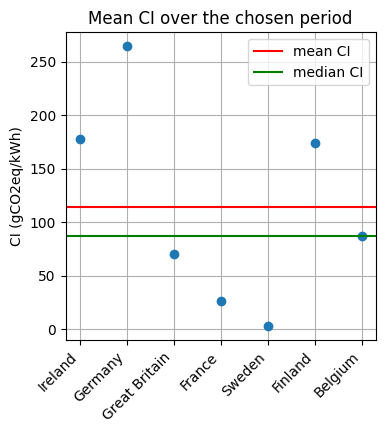

In [5]:
mean_list=[]
for country in countries:
    CI_values=get_CI_values(_dfs, country, start_date, end_date)
    mean_list.append(CI_values.mean())
dict_countries_CI = dict(zip(countries, mean_list))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
plt.plot(countries, mean_list, 'o')
plt.title('Mean CI over the chosen period')
plt.ylabel('CI (gCO2eq/kWh)')
plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
plt.grid()

global_mean_CI = np.array(mean_list).mean()
ax.axhline(y=global_mean_CI, color='r', linestyle='-', label='mean CI')

median_CI = np.median(np.array(mean_list))
ax.axhline(y=median_CI, color='g', linestyle='-', label='median CI')

ax.legend()

plt.savefig('figures/av-mat-2/means.png', bbox_inches='tight')

plt.show()

**Carbon Intensity matrix:**

This matrix contains CI values in gCO2eq/kWh.

In [6]:
# initialize the similarity matrix:
# time_values = pd.to_datetime(datetime_values.astype('datetime64[ns]')).to_list()
# formatted_array = [i for i in range(len(time_values))]
CI_matrix  = pd.DataFrame(index = countries, columns = formatted_array)
for country in countries:
    CI_values=get_CI_values(_dfs, country, start_date, end_date)
    CI_matrix.loc[country, :] = CI_values

**GHG matrix:** 

We suppose that the power draw for all clients is constant and equal. At the moment we take the constant **300 Watts**.

The formula for carbon footprint is: power (W) * duration (hour) * carbon intensity (gCO2/kWh) * 1000

It contains the values of carbon fooprint of sustaining a certain power during ``round_duration`` hours

In [7]:
power = 300/1000 # in kiloWatts
round_duration = 1 # in hours: this is duration of a FL training round
GHG_matrix = CI_matrix * power * round_duration / 1000
GHG_mat_np = GHG_matrix.to_numpy()

We now create availability matrices. First by hand, and then using optimization algorithms.

## Uniform carbon budget 

Each country has the same carbon budget of 1 kgCO2e for each country. Let us now create the availability matrix.

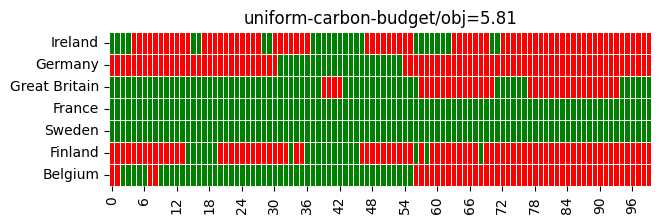

In [8]:
key_word = 'uniform-carbon-budget'
folder = main_folder+'/by_hand'

def availability_from_budget(GHG_values, budget):
    sorted_idx = np.argsort(GHG_values)

    sorted_GHG_values = GHG_values[sorted_idx]

    sorted_GHG_cumsum = np.cumsum(sorted_GHG_values)

    selected_idx = sorted_idx[sorted_GHG_cumsum <= budget]

    availability_seq = np.zeros(len(GHG_values), dtype = np.int8)
    availability_seq[selected_idx] = 1
    availability_seq = np.array(availability_seq, dtype=bool)
    return availability_seq

availability_matrix  = pd.DataFrame(index = countries, columns = formatted_array)
for country in countries:
    GHG_values = GHG_matrix.loc[country, :].to_numpy()
    GHG_values = np.array([np.round(x, 4) for x in GHG_values])

    availability_seq = availability_from_budget(GHG_values, carbon_budget)
  
    # print(GHG_values[availability_seq].sum())

    availability_matrix.loc[country, :] = availability_seq

obj=np.sum(availability_matrix.to_numpy()*GHG_mat_np)

plot_availability_heatmap("Availability with carbon budget", availability_matrix, key_word, folder=folder, objective=obj)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

key_words.append(key_word)
folders.append(folder)

## Uniform carbon budget and fine-tuning

Each country has the same carbon budget

0.26043400000000005
0.06895600000000002
0.8614
0.92155
0.995848
0.567658
0.717577


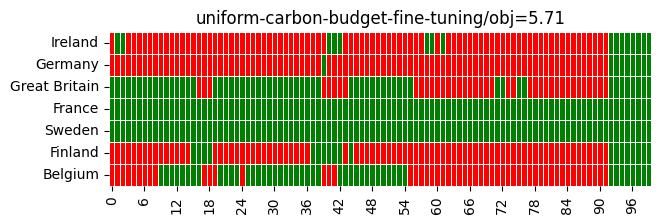

In [9]:
# last 10% of the time is green (available)
# decrease each country carbon budget
# for each country, if some carbon budget is left, then allocate it
key_word = 'uniform-carbon-budget-fine-tuning'
folder = main_folder+'/by_hand'

percentage_fine_tuning = 0.085

availability_matrix  = pd.DataFrame(index = countries, columns = formatted_array)
for country in countries:
    GHG_values = GHG_matrix.loc[country, :].to_numpy()
    idx = int(percentage_fine_tuning*len(GHG_values))

    GHG_country = sum(GHG_values[-idx:])
    remaining_budget = carbon_budget - GHG_country

    print(remaining_budget)

    availability_seq = availability_from_budget(GHG_values, remaining_budget)
    availability_seq[-idx:] = 1

    availability_matrix.loc[country, :] = availability_seq

obj=np.sum(availability_matrix.to_numpy()*GHG_mat_np)

plot_availability_heatmap("Availability with carbon budget and fine-tuning", availability_matrix, key_word, folder=folder, objective=obj)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

key_words.append(key_word)
folders.append(folder)

## Uniform time budget

Here, all countries are available the same amount of time but each country is responsible for a different amount of carbon emissions.

The carbon budget is give for the ensemble of all countries.

6.949430999999999


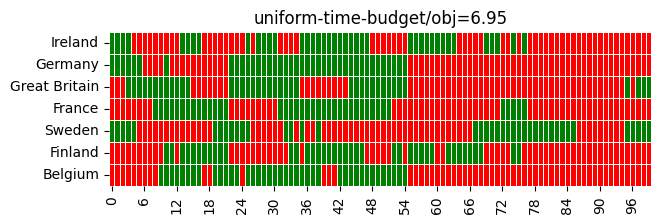

In [10]:
key_word = 'uniform-time-budget'
folder = main_folder+'/by_hand'

GHG_mat_np = GHG_matrix.to_numpy()

GHG_sorted_idx = np.argsort(GHG_mat_np, axis=1)

GHG_sorted = [GHG_mat_np[idx,l] for idx,l in enumerate(GHG_sorted_idx)]

GHG_cumsum = np.cumsum(GHG_sorted, axis=1)

GHG_global_sum = np.sum(GHG_cumsum, axis=0)

threshold_idx = sum(GHG_global_sum < global_carbon_budget)

availability_matrix = np.zeros(GHG_mat_np.shape, dtype = np.int8)
for idx,l in enumerate(GHG_sorted_idx):
    selected_idx = l[:threshold_idx]
    availability_matrix[idx, selected_idx] = 1

# check
print(sum(sum(np.multiply(availability_matrix,GHG_mat_np))))

obj=np.sum(availability_matrix*GHG_mat_np)

# plot
availability_matrix  = pd.DataFrame(availability_matrix, index = countries, columns = formatted_array)
plot_availability_heatmap("Availability with uniform time budget and common carbon budget", availability_matrix, key_word, folder=folder, objective=obj)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

key_words.append(key_word)
folders.append(folder)

## Uniform CI threshold

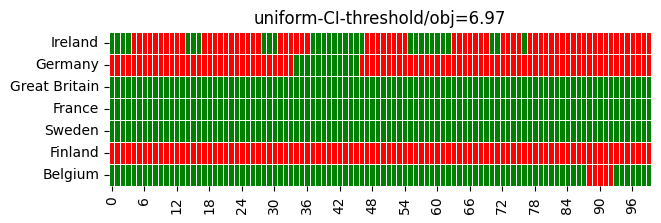

In [11]:
key_word = 'uniform-CI-threshold'
folder = main_folder+'/by_hand'

CI_mat_np = CI_matrix.to_numpy()
CI_values_sorted = np.sort(CI_mat_np, axis=None)

cpt=0
footprint=0
while footprint <= global_carbon_budget and cpt+1 < len(CI_values_sorted):
    cpt+=1
    threshold_tmp = CI_values_sorted[cpt]
    footprint = np.sum(CI_mat_np[CI_mat_np <= threshold_tmp] * power * round_duration / 1000)

threshold = CI_values_sorted[cpt-1]
availability_matrix = np.array(CI_mat_np <= threshold, dtype=np.int8)

obj=np.sum(availability_matrix*GHG_mat_np)

# plot
availability_matrix  = pd.DataFrame(availability_matrix, index = countries, columns = formatted_array)
plot_availability_heatmap("Availability with uniform CI threshold and common carbon budget", availability_matrix, key_word, folder=folder, objective=obj)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

key_words.append(key_word)
folders.append(folder)

## Linear optimization

#### Simplest case

- w_c,t is constant equal to 1
- alpha (alpha faireness) is equal to 1

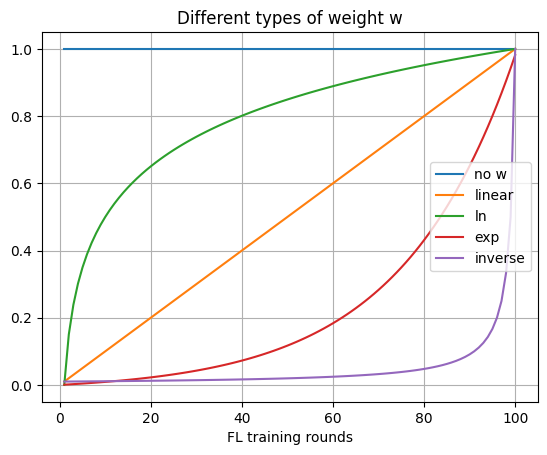

In [47]:
# CHOICE OF W

T_max = n_rounds # in hours

rounds_axis = np.array([i for i in range(1, n_rounds+1)])

w_dict = {
    'no w': np.ones(len(rounds_axis)),
    'linear': 1/T_max*rounds_axis,
    'ln': 1/np.log(T_max)*np.log(rounds_axis),
    'exp': 1/np.exp(T_max/25)*np.exp(rounds_axis/25) - 1/np.exp(T_max/25),
    # 'exp': 1/np.exp(T_max/10)*np.exp(rounds_axis/10) - 1/np.exp(T_max/10),
    'inverse': np.flip(1/rounds_axis)
}

# w = rounds_axis                # linear
# w = np.ones(len(rounds_axis))  # no w
# w = np.log(rounds_axis)        # ln
# w = np.exp(rounds_axis/25)     # exp
# w = np.flip(1/rounds_axis)     # inverse 1/x

################################
###### Here change w ###########
##### use the key in w_dict#####
choice_w = 'exp'
################################
################################

plt.figure()
for key, item in w_dict.items():
    plt.plot(rounds_axis, item, label=key)
plt.legend()
plt.title('Different types of weight w')
plt.xlabel('FL training rounds')
plt.grid()
plt.savefig(main_folder+'/different_w.png', bbox_inches='tight')
plt.show()


w = w_dict[choice_w]

tile_w = np.tile(w, GHG_matrix.shape[0])

# plt.figure()
# plt.plot(w)
# plt.show()

# CHOICE OF ALPHA

alpha_f = 1

**Method 1**: mlip

Objective function:  -14.01638649804581


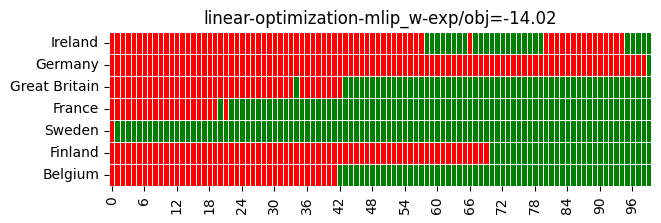

In [48]:
key_word = 'linear-optimization-mlip'+'_w-'+choice_w
folder = main_folder+'/optimization/linear'

# https://docs.scipy.org/doc/scipy/tutorial/optimize.html#mixed-integer-linear-programming


GHG_1d = GHG_matrix.to_numpy().flatten()
values = np.multiply((np.max(GHG_1d) - GHG_1d), tile_w)
sizes = GHG_1d

bounds = optimize.Bounds(0, 1)  # 0 <= x_i <= 1
integrality = np.full_like(values, True)  # x_i are integers

capacity = global_carbon_budget # kgCO2e
constraints = optimize.LinearConstraint(A=sizes, lb=0, ub=capacity)


res = milp(c=-values, constraints=constraints,
           integrality=integrality, bounds=bounds)

print('Objective function: ', -np.dot(values, res.x))

availability_matrix = np.array(res.x, dtype=np.int8).reshape(GHG_matrix.shape)

# plot
availability_matrix  = pd.DataFrame(availability_matrix, index = countries, columns = formatted_array)
plot_availability_heatmap("", availability_matrix, key_word, folder=folder, objective=-np.dot(values, res.x))
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

key_words.append(key_word)
folders.append(folder)

**Method 2**: gekko

Objective function:  -13.986205217


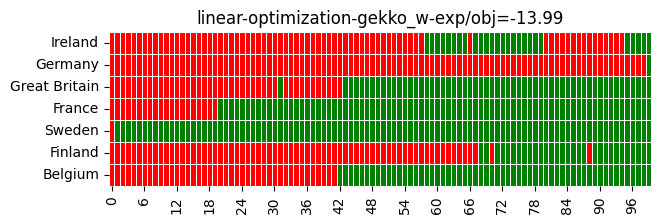

In [49]:
key_word = 'linear-optimization-gekko'+'_w-'+choice_w
folder = main_folder+'/optimization/linear'

# reference: https://apmonitor.com/me575/index.php/Main/PythonOptimization

mod = GEKKO(remote=False)

GHG_1d = GHG_matrix.to_numpy().flatten()
values = np.multiply((np.max(GHG_1d) - GHG_1d), tile_w)
sizes = GHG_1d

x = mod.Array(mod.Var,len(values),lb=0,ub=1,integer=True)

e = [mod.Intermediate(values[i]*x[i]) for i in range(len(values))]
mod.Minimize(-mod.sum(e))

f = [mod.Intermediate(sizes[i]*x[i]) for i in range(len(sizes))]
mod.Equation(mod.sum(f) <= global_carbon_budget)

mod.options.SOLVER=1
mod.solve(disp=False)

#Print the results
print("Objective function: ", mod.options.objfcnval)
# print("Optimal solution: ", x)

sol = [x[i][0] for i in range(len(x))]
availability_matrix = np.array(sol, dtype=np.int8).reshape(GHG_matrix.shape)

# plot
availability_matrix  = pd.DataFrame(availability_matrix, index = countries, columns = formatted_array)
plot_availability_heatmap("", availability_matrix, key_word, folder=folder, objective=mod.options.objfcnval)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

key_words.append(key_word)
folders.append(folder)

**Method 3**: linprog

Objective function:  -14.016386498045817


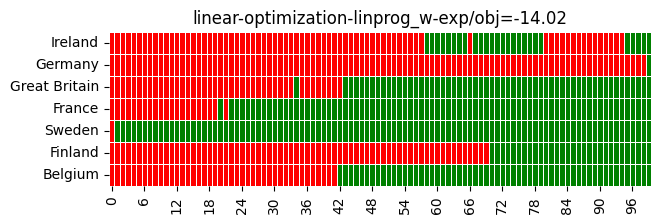

In [50]:
key_word = 'linear-optimization-linprog'+'_w-'+choice_w
folder = main_folder+'/optimization/linear'

# reference: https://apmonitor.com/me575/index.php/Main/PythonOptimization

GHG_1d = GHG_matrix.to_numpy().flatten()
values = np.multiply((np.max(GHG_1d) - GHG_1d), tile_w)
sizes = GHG_1d

#Define the bounds
b = (0, 1)

#Solve
res = linprog(-values, A_ub=sizes.reshape(1, len(sizes)), b_ub=global_carbon_budget, bounds=(b),
              integrality=[1 for i in range(len(values))])

#Print the results
print("Objective function: ", res.fun)
# print("Optimal solution: ", res.x)

availability_matrix = np.array(res.x, dtype=np.int8).reshape(GHG_matrix.shape)

# plot
availability_matrix  = pd.DataFrame(availability_matrix, index = countries, columns = formatted_array)
plot_availability_heatmap("", availability_matrix, key_word, folder=folder, objective=res.fun)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

key_words.append(key_word)
folders.append(folder)

**Method 4:** cvxpy

Objective:  -14.01626047920468


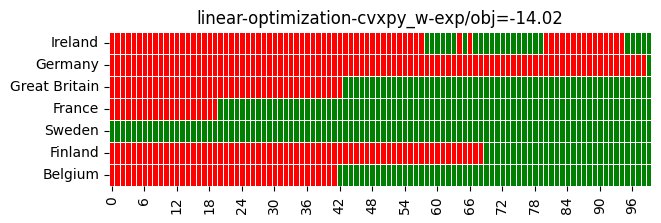

In [51]:
key_word = 'linear-optimization-cvxpy'+'_w-'+choice_w
folder = main_folder+'/optimization/linear'

# reference: https://www.cvxpy.org/

GHG_1d = GHG_matrix.to_numpy().flatten()
values = np.multiply((np.max(GHG_1d) - GHG_1d), tile_w)
sizes = GHG_1d

# Problem data.

# Construct the problem.
x = cp.Variable(len(GHG_1d), integer=True)
objective = cp.Minimize(-cp.sum(cp.multiply(values, x)))
constraints = [0 <= x, x <= 1, cp.sum(cp.multiply(sizes, x))<=global_carbon_budget]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
print('Objective: ', result)
# The optimal value for x is stored in `x.value`.
# print(x.value)

availability_matrix = np.array(x.value, dtype=np.int8).reshape(GHG_matrix.shape)

# plot
availability_matrix  = pd.DataFrame(availability_matrix, index = countries, columns = formatted_array)
plot_availability_heatmap("", availability_matrix, key_word, folder=folder, objective=result)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

key_words.append(key_word)
folders.append(folder)

## Nonlinear Optimization

**Method 1:** greedy by hand

objective: 13.996120858282069


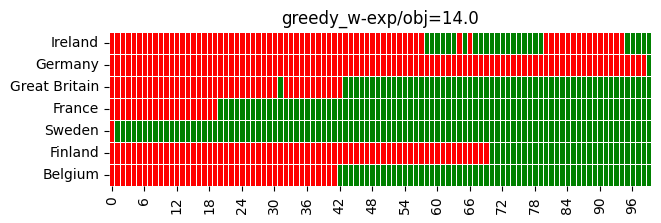

In [52]:
key_word = 'greedy'+'_w-'+choice_w
folder = main_folder+'/optimization/nonlinear'

alpha_f=1




class our_problem(object):
    def __init__(self, GHG_matrix, alpha_f, w):
        self.GHG_mat = GHG_matrix.to_numpy()
        self.one_m_GHG_w = (np.max(self.GHG_mat) - self.GHG_mat)@np.diag(w)
        # self.one_m_GHG_w = (1 - self.GHG_mat/np.max(self.GHG_mat))@np.diag(w) # test
        # self.one_m_GHG_w = (np.diag(np.max(self.GHG_mat, axis=1))@np.ones((n_clients, n_rounds)) - self.GHG_mat)@np.diag(w) # test
        self.GHG_w = self.GHG_mat@np.diag(w) # test
        self.A = np.zeros(self.GHG_mat.shape)
        self.alpha_f = alpha_f
        self.n_clients = GHG_matrix.shape[0]
        self.n_rounds = GHG_matrix.shape[1]

    def obj_func(self, A):
        # remove the minus here if you want to maximize instead of minimizing (argmin -> argmax):
        return np.sum(np.power(np.sum(np.multiply(self.one_m_GHG_w, A), axis=1), self.alpha_f))
        # return np.sum(np.power(np.sum(np.multiply(self.GHG_w, A), axis=1), self.alpha_f)) # test
        # return np.sum(np.power(np.sum(np.multiply(self.GHG_w, np.ones(A.shape) - A), axis=1), self.alpha_f)) # test
    
        # return -np.sum(np.sum(np.multiply(self.one_m_GHG_w, A), axis=1))

    def diff(self, i, j):
        A_new = copy.copy(self.A)
        A_new[i, j] = 1
        # return self.obj_func(A_new) - self.obj_func(self.A)
        return (self.obj_func(A_new) - self.obj_func(self.A))/self.GHG_mat[i, j] # test
        # return self.obj_func(A_new) # something else we can optimize
    
    def update_A(self, i_star, j_star):
        self.A[i_star, j_star] = 1


def greedy_optimize(pb):
    indexes = [(i, j) for i in range(n_clients) for j in range(n_rounds)]
    mask = np.array([0 for i in range(n_clients) for j in range(n_rounds)])
    G = 7

    while True:
        values = np.array([pb.diff(*idx) for idx in indexes])

        shuf_order = np.arange(len(values))
        shuf_values = values[shuf_order]
        shuf_mask = mask[shuf_order]
        # unshuf_order = np.zeros(len(values), dtype=np.int8)
        # unshuf_order[shuf_order] = np.arange(len(values))

        masked_arr = np.ma.masked_array(shuf_values, shuf_mask)
        # shuf_res = masked_arr.argmin()
        shuf_res = masked_arr.argmax()

        res = shuf_order[shuf_res]

        i_star = res//n_rounds
        j_star = res - i_star*n_rounds

        G -= pb.GHG_mat[i_star, j_star]
        if G < 0:
            break

        pb.update_A(i_star, j_star)
        mask[res] = 1
        # indexes.remove((i_star, j_star))
    # return pb


pb = our_problem(GHG_matrix, alpha_f, w)
greedy_optimize(pb)

print('objective:', pb.obj_func(pb.A))

# plot
availability_matrix  = pd.DataFrame(pb.A, index = countries, columns = formatted_array)
plot_availability_heatmap("", availability_matrix, key_word, folder=folder, objective=pb.obj_func(pb.A))
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

key_words.append(key_word)
folders.append(folder)

**Method 2:** cvxpy

NOT WORKING for alpha<1:

SolverError: Solver 'GUROBI' failed. Try another solver, or solve with verbose=True for more information.

In [53]:
key_word = 'nonlinear-optimization-cvxpy'+'_w-'+choice_w
folder = main_folder+'/optimization/nonlinear'


##### Change alpha here #####
alpha_f = 0.5
#############################

# reference: https://www.cvxpy.org/

GHG_mat = GHG_matrix.to_numpy()
one_m_GHG_w = (np.max(GHG_mat) - GHG_mat)@np.diag(w)
# GHG_w = GHG_mat@np.diag(w) # test

# Construct the problem.
x = cp.Variable(GHG_mat.shape, integer=True)

objective = cp.Minimize(-cp.sum(cp.power(cp.sum(cp.multiply(one_m_GHG_w, x), axis=1), alpha_f))) # NONLINEAR does not work
# objective = cp.Minimize(-cp.sum(cp.power(cp.sum(cp.multiply(GHG_w, np.ones(GHG_mat.shape) - x), axis=1), alpha_f))) # test
# objective = cp.Minimize(-cp.sum(cp.sum(cp.multiply(one_m_GHG_w, x), axis=1))) # without alpha

constraints = [0 <= x, x <= 1, cp.sum(cp.multiply(GHG_mat, x))<=global_carbon_budget]
# constraints = [0 <= x[i, j] for i in range(x.shape[0]) for j in range(x.shape[1])]+[x[i, j] <= 1 for i in range(x.shape[0]) for j in range(x.shape[1])]+[cp.sum(cp.multiply(GHG_mat, x))<=global_carbon_budget]

prob = cp.Problem(objective, constraints)
# result = prob.solve(solver=cp.SCIPY, scipy_options={'method':'highs'}) # optimal objective
# result = prob.solve(solver=cp.SCS, verbose=True, use_indirect=True) 

# result = prob.solve(solver=cp.GUROBI, verbose=True)
result = prob.solve(solver=cp.GUROBI, verbose=True)

# solvers not installed: CVXOPT, CBC, CPLEX, NAG


# print(x.value) # optimal value



availability_matrix = np.array(x.value, dtype=np.int8)

# plot
availability_matrix  = pd.DataFrame(availability_matrix, index = countries, columns = formatted_array)
plot_availability_heatmap("", availability_matrix, key_word, folder=folder, objective=x.value)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

key_words.append(key_word)
folders.append(folder)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 16 11:19:20 AM: Your problem has 700 variables, 1401 constraints, and 0 parameters.
(CVXPY) Jul 16 11:19:20 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 16 11:19:20 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 16 11:19:20 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 16 11:19:20 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 16 11:19:20 AM: Compiling problem (target solver=GUROBI)

SolverError: Solver 'GUROBI' failed. Try another solver, or solve with verbose=True for more information.

**Method 3:** gekko

NOT WORKING for alpha<1: 

Exception: @error: Solution Not Found

In [ ]:
alpha_f = 0.5


key_word = 'nonlinear-optimization-gekko'+'_w-'+choice_w
folder = main_folder+'/optimization/nonlinear'

# reference: https://apmonitor.com/me575/index.php/Main/PythonOptimization

mod = GEKKO(remote=False)

# GHG_mat = GHG_matrix.to_numpy()
# one_m_GHG_w = (np.max(GHG_mat) - GHG_mat)@np.diag(w)

GHG_1d = GHG_matrix.to_numpy().flatten()
values = np.multiply((np.max(GHG_1d) - GHG_1d), tile_w)
# values = np.multiply(GHG_1d, tile_w) # test
sizes = GHG_1d

x = mod.Array(mod.Var,len(values),lb=0,ub=1,integer=True)

# e = [mod.Intermediate(values[i]*x[i]) for i in range(len(values))]

e = [mod.Intermediate(mod.sum([mod.Intermediate(values[j+i*n_rounds]*x[j+i*n_rounds]) for j in range(n_rounds)])**alpha_f) for i in range(n_clients)]
# e = [mod.Intermediate(mod.sum([mod.Intermediate(values[j+i*n_rounds]*(1-x[j+i*n_rounds])) for j in range(n_rounds)])**alpha_f) for i in range(n_clients)] # test
# mod.Minimize(-mod.sum(e))
mod.Maximize(mod.sum(e)) # test

f = [mod.Intermediate(sizes[i]*x[i]) for i in range(len(sizes))]
mod.Equation(mod.sum(f) <= global_carbon_budget)
# f = [mod.Intermediate(sizes[i]*x[i]) for i in range(len(sizes))] # test
# mod.Equation(mod.sum(f) <= global_carbon_budget) # test

mod.options.SOLVER=1
mod.solve(disp=False)

#Print the results
print("Objective function: ", mod.options.objfcnval)
# print("Optimal solution: ", x)

sol = [x[i][0] for i in range(len(x))]
availability_matrix = np.array(sol, dtype=np.int8).reshape(GHG_matrix.shape)

# plot
availability_matrix  = pd.DataFrame(availability_matrix, index = countries, columns = formatted_array)
plot_availability_heatmap("", availability_matrix, key_word, folder=folder, objective=mod.options.objfcnval)
save_availability_matrix(datetime_values, formatted_array, key_word, availability_matrix)

key_words.append(key_word)
folders.append(folder)

Exception: @error: Solution Not Found


## Random availability matrix equivalents

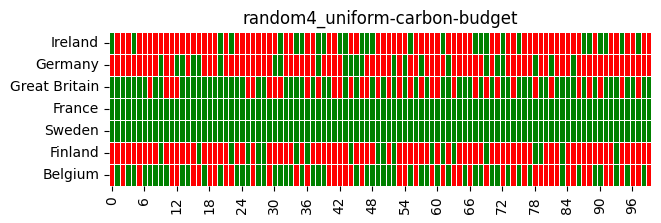

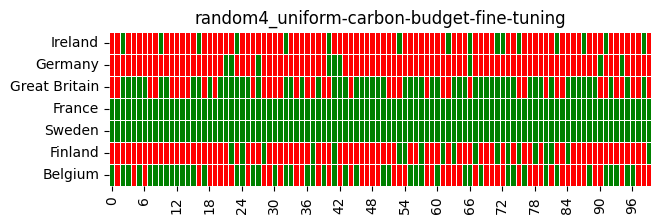

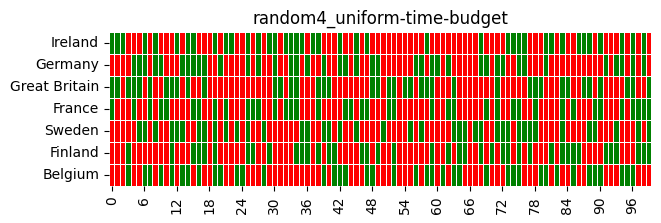

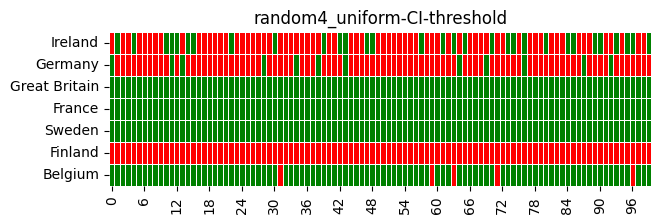

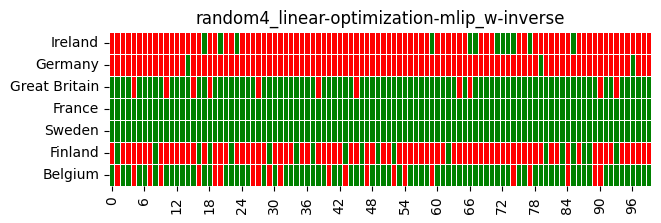

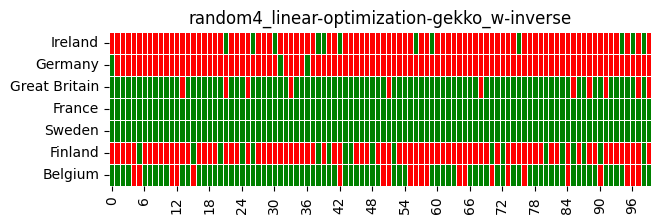

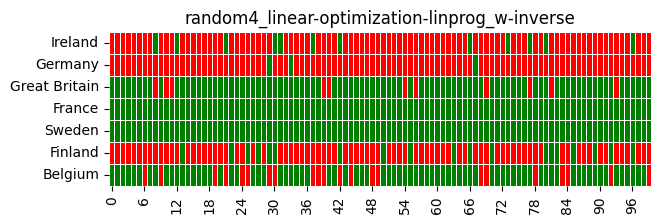

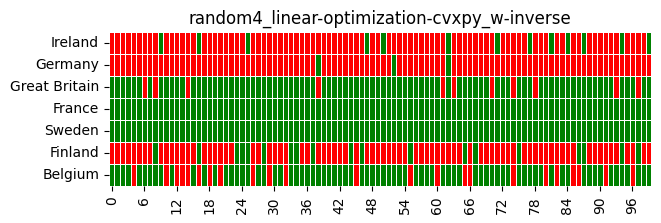

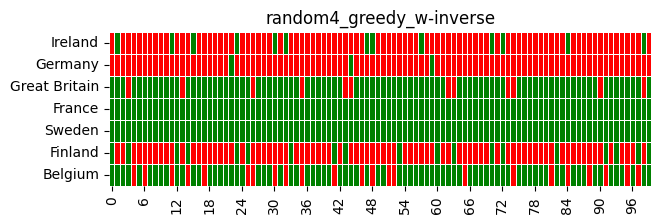

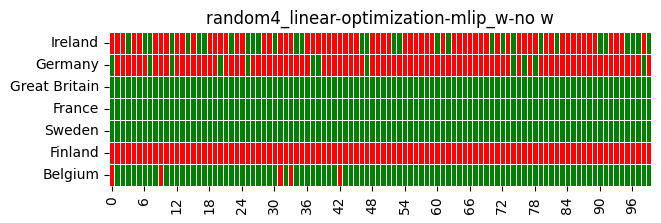

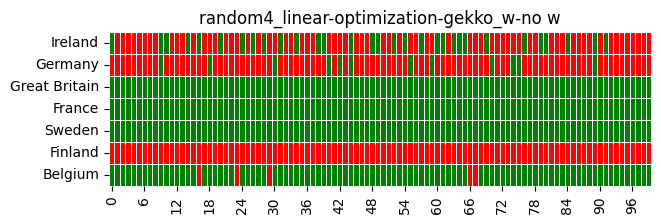

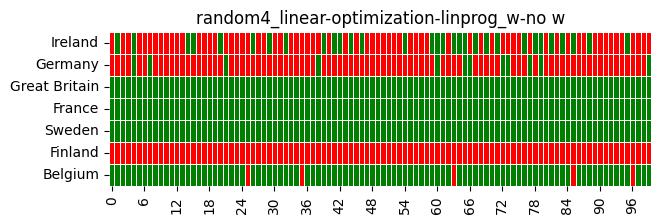

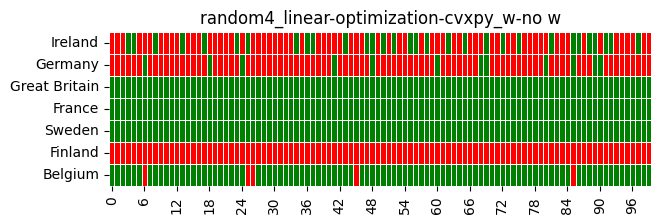

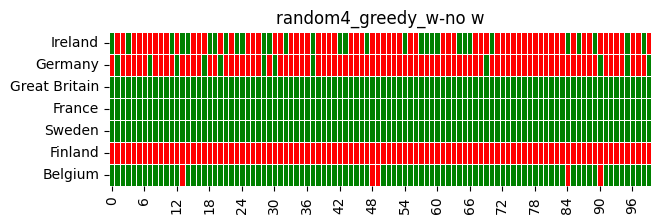

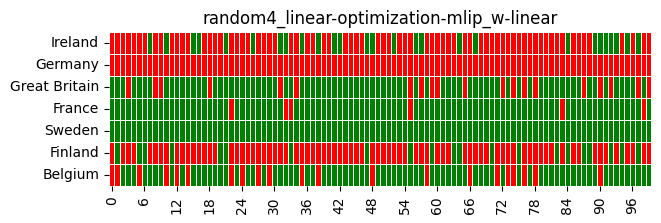

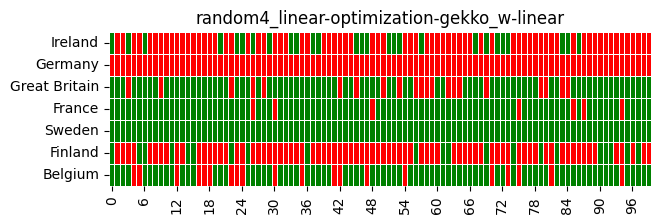

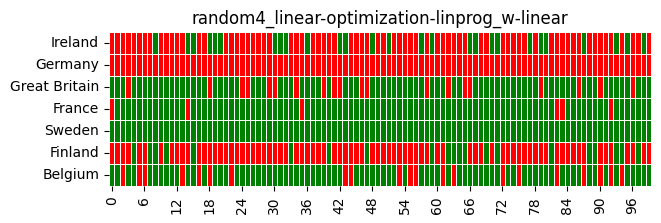

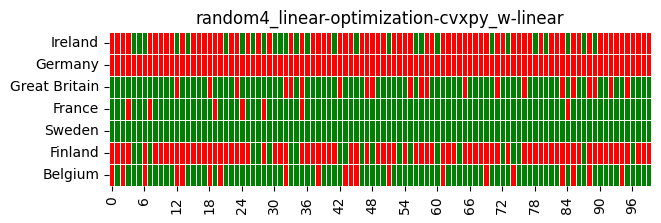

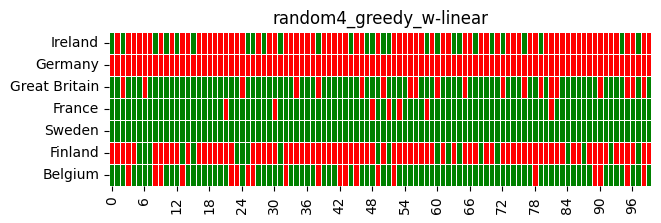

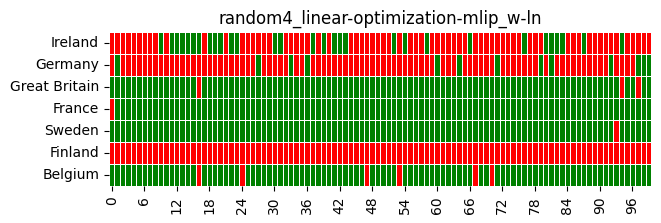

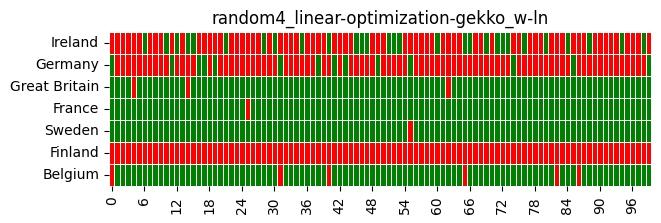

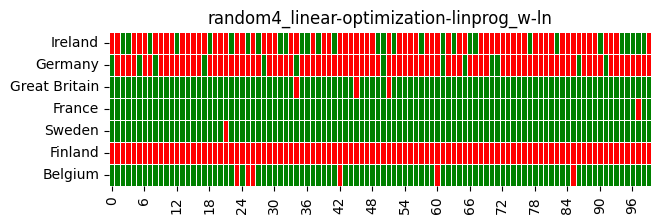

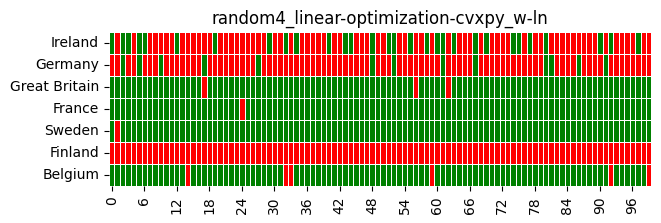

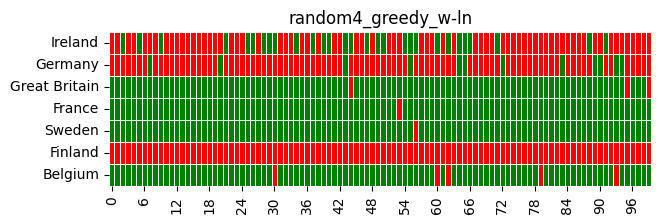

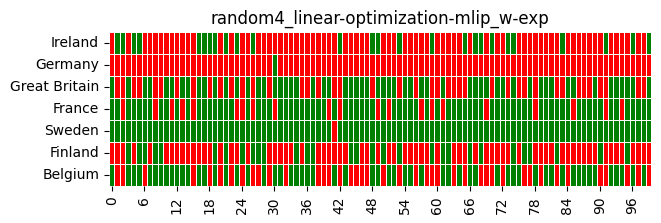

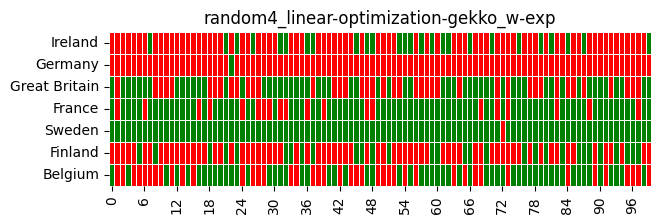

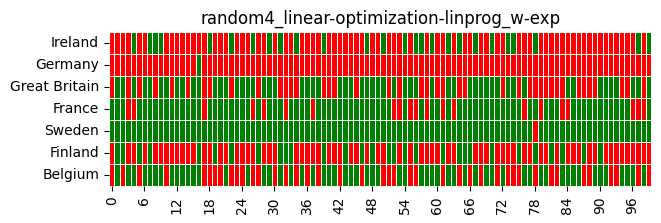

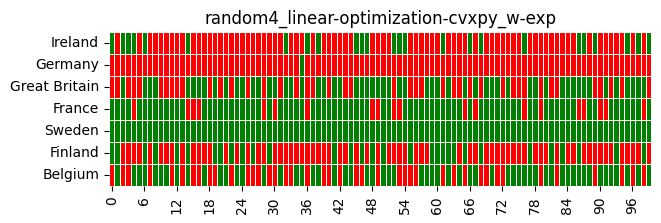

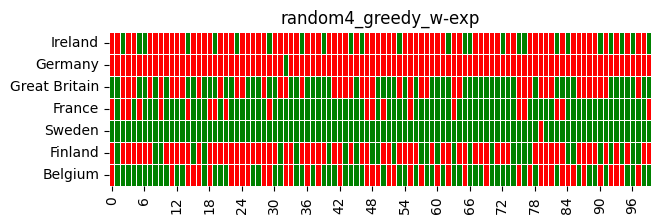

In [54]:
def create_matrix_with_zeros(num_rows, num_cols, num_zeros_per_row):
    # Create a matrix filled with ones
    matrix = np.ones((num_rows, num_cols), dtype=int)

    # Randomly set zeros in each row
    for i in range(num_rows):
        # Validate input
        if num_zeros_per_row[i] < 0 or num_zeros_per_row[i] > num_cols:
            raise ValueError("Invalid number of zeros per row.")
        indices = np.random.choice(num_cols, num_zeros_per_row[i], replace=False)
        matrix[i, indices] = 0

    return matrix

key_words_list = ['uniform-carbon-budget', 'uniform-carbon-budget-fine-tuning', 'uniform-time-budget', 'uniform-CI-threshold', 'linear-optimization-mlip']

for key_word, folder in zip(key_words, folders):

    df = pd.DataFrame(pd.read_csv("availability_matrices/av-mat-2/av-mat_"+key_word+".csv", index_col=[0]))

    num_zeros_per_row = df.apply(lambda row: (row == 0).sum(), axis=1).values

    values = create_matrix_with_zeros(len(countries), len(formatted_array), num_zeros_per_row)

    # obj = np.sum(values*GHG_mat_np)

    availability_matrix  = pd.DataFrame(values, index = countries, columns = formatted_array)

    save_availability_matrix(datetime_values, formatted_array, 'random4_'+key_word, availability_matrix)
    plot_availability_heatmap("", availability_matrix, 'random4_'+key_word, folder=folder)

In [55]:
random_key_words = ['random4_'+e for e in key_words]

print((' ').join(key_words_list) + ' ' + (' ').join(random_key_words))

uniform-carbon-budget uniform-carbon-budget-fine-tuning uniform-time-budget uniform-CI-threshold linear-optimization-mlip random4_uniform-carbon-budget random4_uniform-carbon-budget-fine-tuning random4_uniform-time-budget random4_uniform-CI-threshold random4_linear-optimization-mlip_w-inverse random4_linear-optimization-gekko_w-inverse random4_linear-optimization-linprog_w-inverse random4_linear-optimization-cvxpy_w-inverse random4_greedy_w-inverse random4_linear-optimization-mlip_w-no w random4_linear-optimization-gekko_w-no w random4_linear-optimization-linprog_w-no w random4_linear-optimization-cvxpy_w-no w random4_greedy_w-no w random4_linear-optimization-mlip_w-linear random4_linear-optimization-gekko_w-linear random4_linear-optimization-linprog_w-linear random4_linear-optimization-cvxpy_w-linear random4_greedy_w-linear random4_linear-optimization-mlip_w-ln random4_linear-optimization-gekko_w-ln random4_linear-optimization-linprog_w-ln random4_linear-optimization-cvxpy_w-ln random